In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
import vice

import surp
from surp import subgiants

import arya
arya.style.set_size((10/3, 10/3))

In [5]:
def translate_label(s):
    return "[" + s.lower().replace("_", "/").replace("mg", "o") + "]"

def find_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the csv summary
    """
    
    file_name = "../out/" + name + ".csv"
    model =  pd.read_csv(file_name, index_col=0)
    model["[c/n]"] = model["[c/o]"] - model["[n/o]"]
    return model

In [11]:
data_kwargs = dict(
    color="k", 
    stat="median",
    err_kwargs=dict(facecolor="k", alpha=0.3)
)

model_kwargs = dict(
    stat="median", errorbar=None,
    aes="line"
)

def zooh_models(models, labels, y="C_MG", sequential=False, **kwargs):
    kwargs = dict(numbins=20, **kwargs)
    
    N = len(models)
    if sequential:
        hm = arya.figure.colorbar.HueMap(clim=(0, len(models)))
    for i in range(N):
        name = labels[i]
        model = models[i]
        fe_h = -model["[o/fe]"] + model["[o/h]"]
        mg_fe = model["[o/fe]"]
        filt = surp.gce_math.is_high_alpha(mg_fe, fe_h)
        
        if sequential:
            color = hm(i)
        else:
            color=None
        arya.medianplot(model[filt], x="[o/h]", y=translate_label(y), label=name, color=color, **model_kwargs, **kwargs)


    df = subgiants[~subgiants.high_alpha]
    
    arya.medianplot(df, x="MG_H", y=y, zorder=-2, **data_kwargs, **kwargs)
    
    
def zofeo_models(models, labels, y="C_MG", sequential=False, mg_0=-0.1, w=0.05, **kwargs):
    kwargs = dict(numbins=12,  **kwargs)

    N = len(models)

    if sequential:
        hm = arya.figure.colorbar.HueMap(clim=(0, len(models)))
    for i in range(N):
        model = models[i]
        filt = model["[o/h]"] > mg_0 - w
        filt &= model["[o/h]"] < mg_0 + w
        df = model[filt].copy()
        if sequential:
            color = hm(i)
        else:
            color=None
        arya.medianplot(df, x="[o/fe]", y=translate_label(y), label=labels[i], color=color, **model_kwargs, **kwargs)
    
    filt = subgiants["MG_H"] > mg_0 - w
    filt &= subgiants["MG_H"] < mg_0 + w
    df = subgiants[filt]

    arya.medianplot(df, x="MG_FE", y=y, **data_kwargs, **kwargs)

In [12]:
def names_to_models(names):
    return [find_model(name) for name in names]

In [13]:
def compare_cooh(names, labels, **kwargs):
    models = names_to_models(names)
    zooh_models(models, labels, **kwargs)
    arya.Legend(color_only=True)
    plt.xlabel("[Mg/H]")
    plt.ylabel("[C/Mg]")
    
    plt.ylim(-0.3, 0.025)
    plt.yticks(np.arange(-0.25, 0.02, 0.05))
    plt.xlim(-0.45, 0.35)

In [14]:
def compare_coofe(names, labels, legend=True, **kwargs):
    models = names_to_models(names)
    zofeo_models(models, labels, legend=legend, **kwargs)
    if legend:
        arya.Legend(color_only=True)
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")


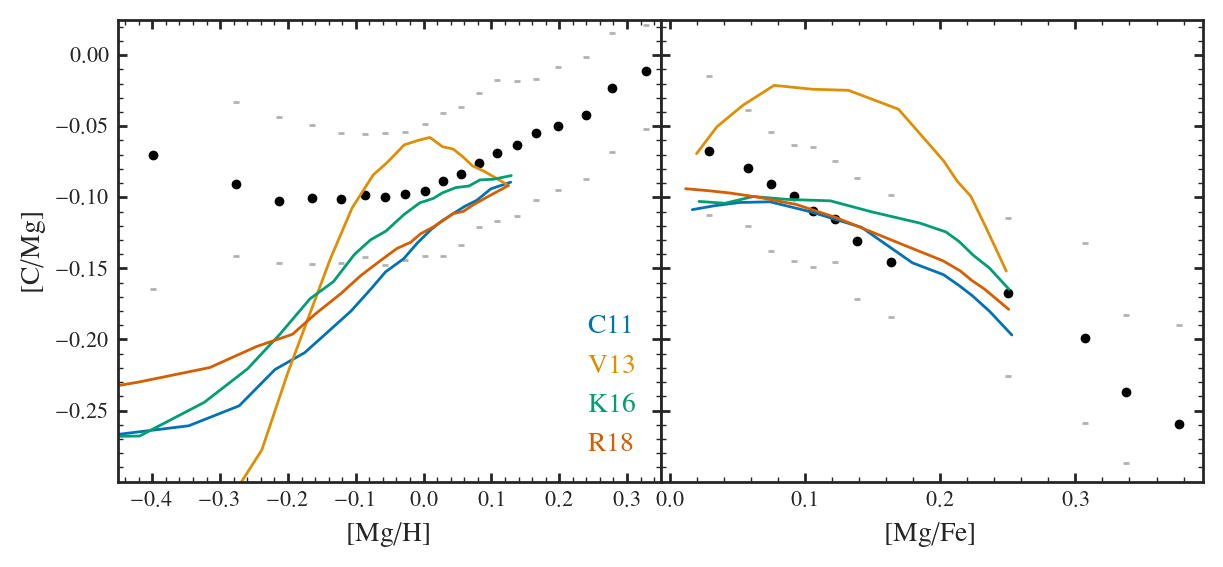

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

names = [    
    "C11_f0.2",
    "V13_f0.2",
    "K16_f0.2",
    "P16_f0.2",
  ]

labels = ["C11", "V13", "K16",  "R18"]
plt.sca(axs[0])
compare_cooh(names, labels)
arya.Legend(color_only=True)
plt.sca(axs[1])
compare_coofe(names, labels, legend=False)

plt.savefig("figures/sims_agb.pdf")

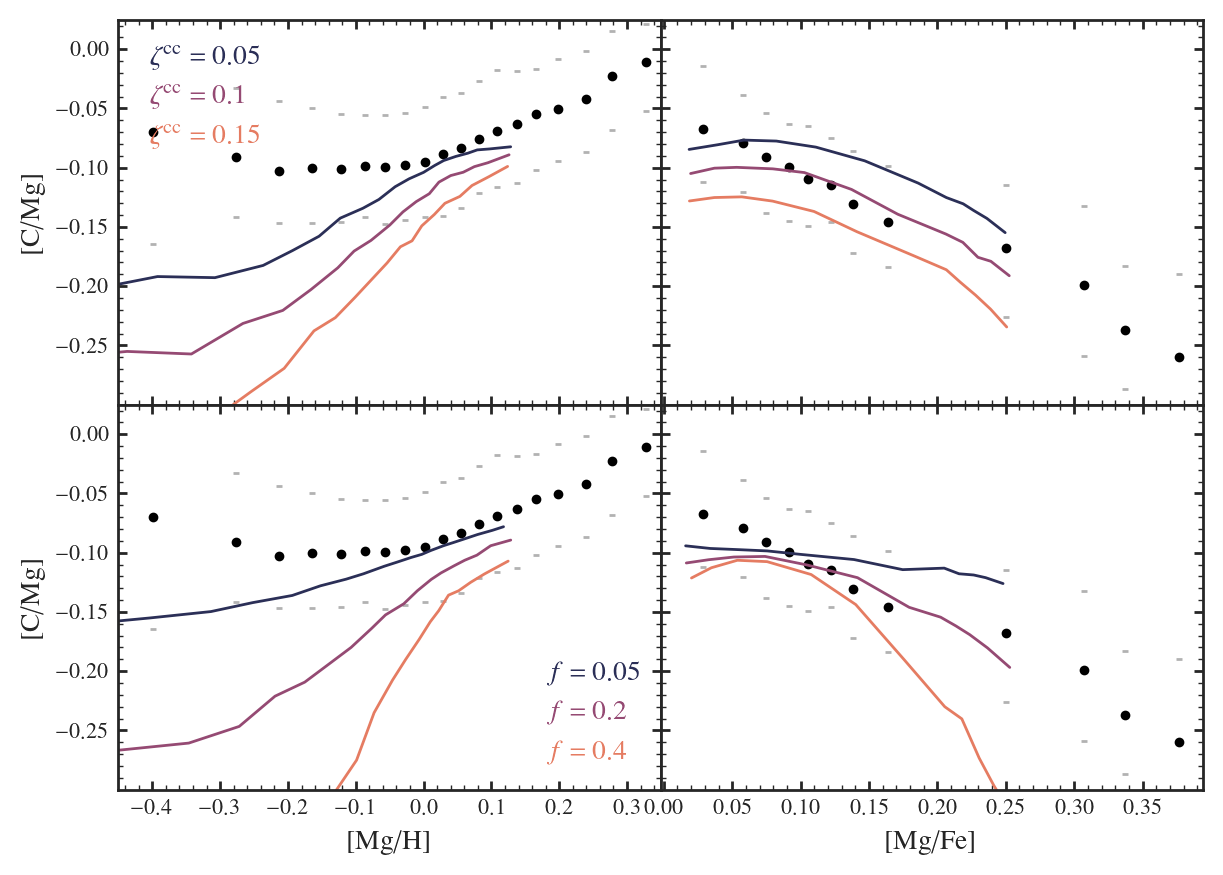

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex="col", sharey=True, gridspec_kw={"wspace": 0, "hspace": 0})


names = [
    "C11_f0.2_zeta0.03",
    "C11_f0.2_zeta0.05",
    "C11_f0.2_zeta0.07",
]
labels = [
    r"$\zeta^{\rm cc}=0.05$", 
    r"$\zeta^{\rm cc}=0.1$", 
    r"$\zeta^{\rm cc}=0.15$"
]

plt.sca(axs[0][0])
compare_cooh(names, labels, sequential=True)
plt.sca(axs[0][1])
compare_coofe(names, labels, sequential=True, legend=False)





names = [    
    "C11_f0.05",
    "C11_f0.2",
    "C11_f0.4",
  ]
labels = ["$f=0.05$", "$f=0.2$", "$f=0.4$"]
plt.sca(axs[1][0])
compare_cooh(names, labels, sequential=True)
plt.sca(axs[1][1])
compare_coofe(names, labels, sequential=True, legend=False)






plt.savefig("figures/sims_zeta_f.pdf")

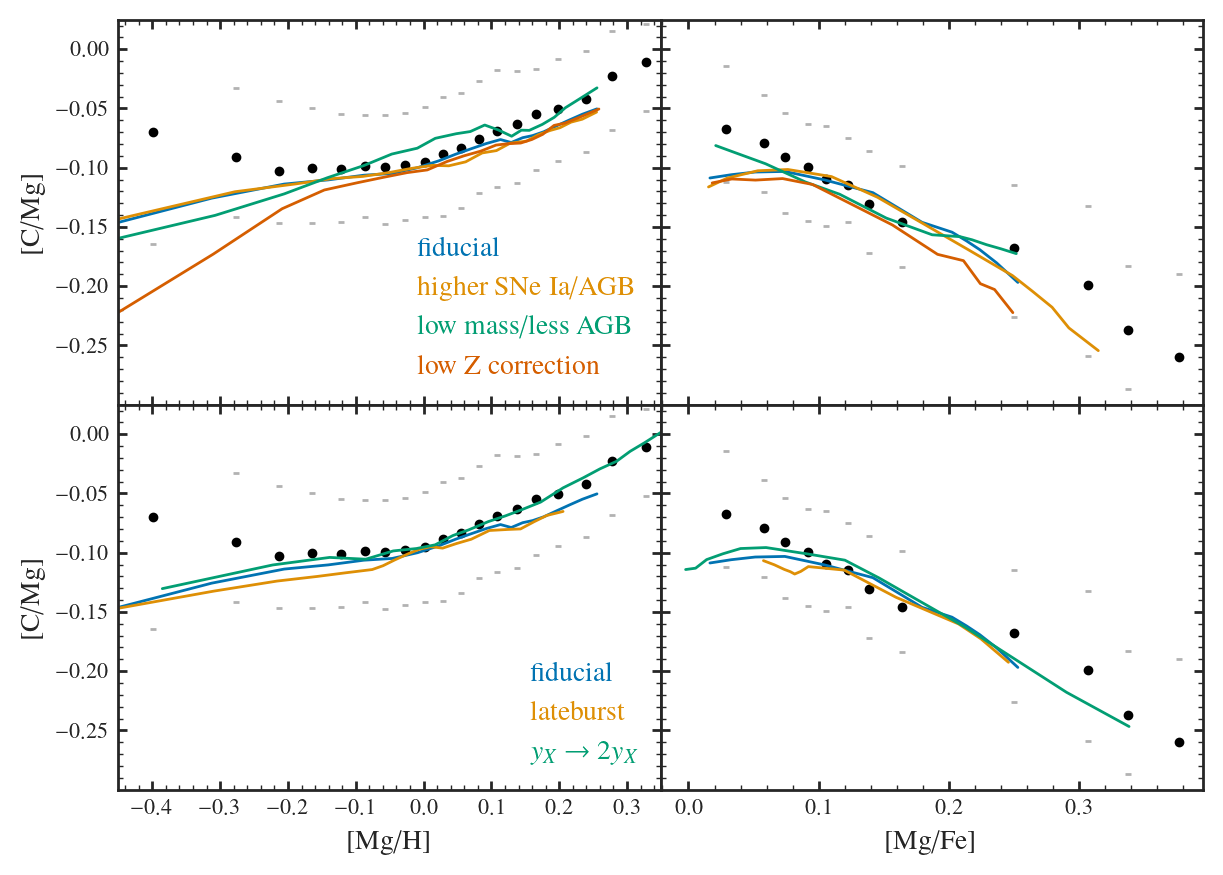

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex="col", sharey="row", gridspec_kw={"wspace": 0, "hspace": 0})



names = [
    "C11_f0.2",
    "C11_f0.3_Fe1.2",
    "C11_m1.5_P_f0.1",
    "C11_f0.2_y1_0.000867_z1_0.008",

        ]

labels=["fiducial", r"higher SNe Ia/AGB", r"low mass/less AGB", "low Z correction"]

plt.sca(axs[0][0])
compare_cooh(names, labels)
arya.Legend(loc="lower right", color_only=True)
plt.sca(axs[0][1])
compare_coofe(names, labels, legend=False)

names = [
    "C11_f0.2",
    "C11_f0.2_lateburst1",
    "C11_f0.2_eta2.0"
        ]

labels=["fiducial", "lateburst", r"$y_X\rightarrow 2y_X$"]
plt.sca(axs[1][0])
compare_cooh(names, labels)
arya.Legend(loc="lower right", color_only=True)
plt.sca(axs[1][1])
compare_coofe(names, labels, legend=False)




plt.savefig("figures/sims_degens.pdf")

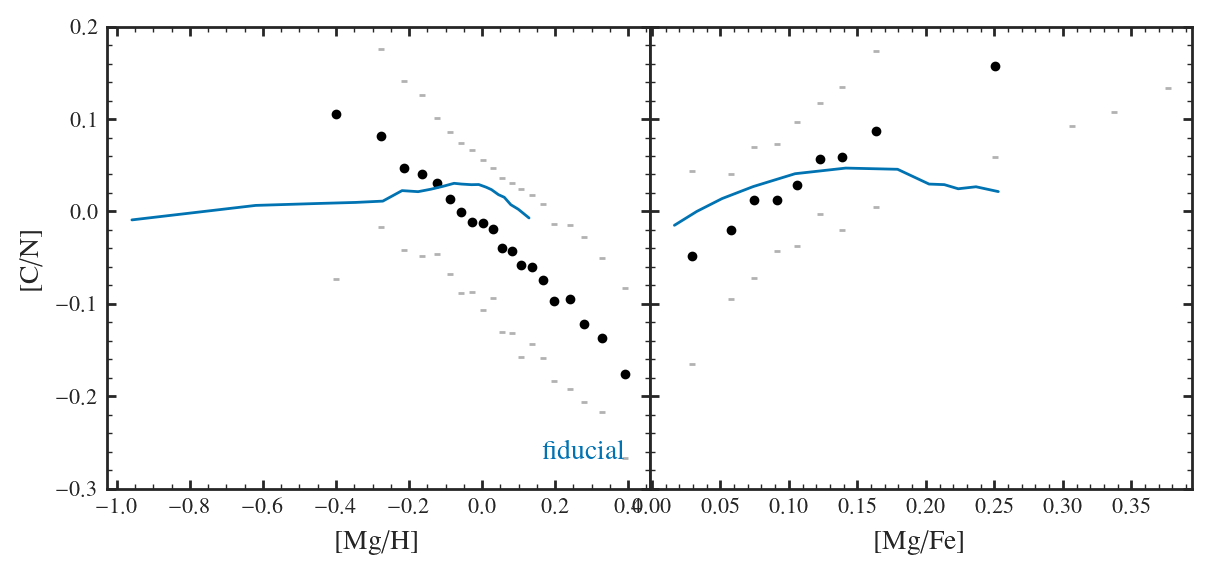

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey="row", gridspec_kw={"wspace": 0, "hspace": 0})


names = ["C11_f0.2"]
labels = ["fiducial"]

plt.sca(axs[0])
models = names_to_models(names)
zooh_models(models, labels, y="C_N")
plt.ylabel("[C/N]")
arya.Legend(loc="lower right", color_only=True)
plt.xlabel("[Mg/H]")
plt.ylim(-0.3, 0.2)

plt.sca(axs[1])
zofeo_models(models, labels, y="C_N", legend=False)
plt.xlabel("[Mg/Fe]")

plt.savefig("figures/c_n.pdf")

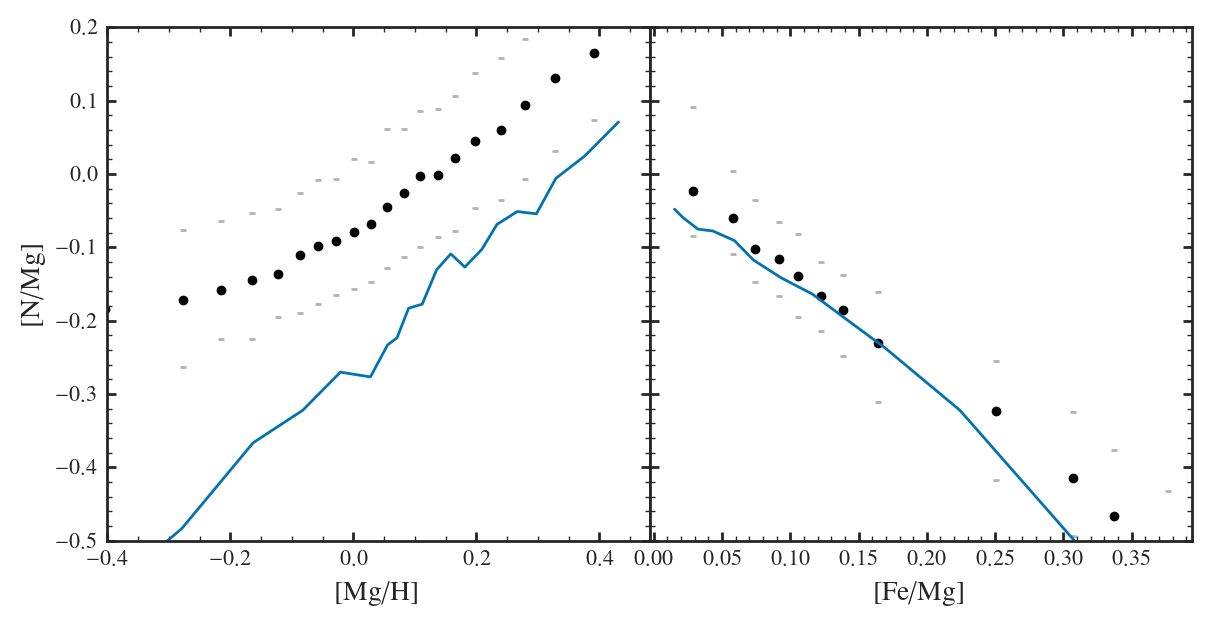

In [20]:
names = ["C11_f0.2_rand_walk_an1.0",
        ]
labels = ["", "f"]


fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw=dict(wspace=0), figsize=(7, 10/3))

plt.sca(axs[0])

models = names_to_models(names)
zooh_models(models, labels, y="N_MG")

plt.xlabel("[Mg/H]")
plt.ylabel("[N/Mg]")
plt.xlim(-0.4)

plt.sca(axs[1])

models = names_to_models(names)
zofeo_models(models, labels, y="N_MG")

plt.xlabel("[Fe/Mg]")
plt.ylabel("[N/Mg]")

plt.ylim(-0.5, 0.2)

plt.savefig("figures/nitrogen.pdf")